# New Notebook : OLS and Lasso

In [1]:
import numpy as np
import pandas as pd
import pprint
import matplotlib
import matplotlib.pyplot as plt        
import sys

sys.path.append('../scripts/')
from models import BaseModels, DataCleaner, ModelPlots, DataModel

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")
counts = pd.read_pickle('../data/monthsCount__0.pckl')
data_cleaner = DataCleaner(speeds, segmentsMeta, mergeResults, counts)
speedDF = data_cleaner.data
countDF = data_cleaner.counts
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67

data_model = DataModel(speedDF, 1, output_lag, sequence_length, valid_split = valid_split, scale_max = False, shift_mean=False)
data_model.preprocessData()
X_train, y_train, X_test, y_test = data_model.trainSplit()

## Normalization

Goal: Z(i) = Z(i) - 1/n Somme sur j  Z(j)

In [3]:
Z = []

for i in range(int((speedDF.shape[1])/20)):
    Z.append(speedDF.iloc[:,i*20:(i+1)*20].values)

print("Z Created!")
n = len(Z)
print("n =", n)

Z = np.array(Z)

Z_train = Z[:44]
Z_test = Z[44:]

M = (1/44)*Z_train.sum(axis=0)

for i in range(44):
    Z_train[i] = Z_train[i] - M
for i in range(65-44):
    Z_test[i] = Z_test[i] - M
    
print("Z Normalized !")

Z Created!
n = 65
Z Normalized !


In [4]:
Z_train[:,1,3].mean()

-2.4223047810003414e-16

In [5]:
def X_Y(Z):
    new_X = Z[:,:,:-1]
    new_Y = Z[:,:,1:]
    new_X = np.concatenate(new_X, axis=1)
    new_Y = np.concatenate(new_Y, axis=1)
    return new_X.T, new_Y.T

def concat_train_test(Z):
    Z_concat = np.concatenate(Z, axis=1)
    Z_train = Z_concat[:, :int(Z_concat.shape[1]*0.67)].T
    Z_test = Z_concat[:,int(Z_concat.shape[1]*0.67):].T
    return Z_train, Z_test

In [6]:
new_X_train, new_Y_train  = X_Y(Z_train)
print(new_X_train.shape, new_Y_train.shape)
new_X_test, new_Y_test = X_Y(Z_test)
print(new_X_test.shape, new_Y_test.shape)

(836, 556) (836, 556)
(399, 556) (399, 556)


In [151]:
X_train.reshape(X_train.shape[0],-1).shape, y_train.shape

((827, 556), (827, 556))

## OLS

In [31]:
%%time
A = [linear_model.LinearRegression() for i in range(nSegments)]

for i in range(nSegments):
    A[i].fit(X_train.reshape(X_train.shape[0],-1), y_train[:, i])

CPU times: user 3min 24s, sys: 1min 36s, total: 5min
Wall time: 1min 17s


In [56]:
preds = []

for i in range(nSegments):
    preds.append(A[i].predict(X_test.reshape(X_test.shape[0],-1)))

preds = np.array(preds)

In [60]:
print("MSE:", mean_squared_error(preds.T.flatten(), y_test.flatten()))
print("MAE:", mean_absolute_error(preds.T.flatten(), y_test.flatten()))

MSE: 313.8508580721112
MAE: 13.201120910650387


## LASSO

In [67]:
%%time
A_lasso = [linear_model.Lasso(alpha=0.1, max_iter=1000, tol=0.0001) for i in range(nSegments)]

for i in range(nSegments):
    A_lasso[i].fit(X_train.reshape(X_train.shape[0],-1), y_train[:, i])

/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You 

CPU times: user 16min 35s, sys: 1.79 s, total: 16min 36s
Wall time: 16min 42s


/home/maxime/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [70]:
preds_lasso = []

for i in range(nSegments):
    preds_lasso.append(A_lasso[i].predict(X_test.reshape(X_test.shape[0],-1)))

preds_lasso = np.array(preds_lasso)

In [71]:
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), y_test.flatten()))

MSE: 259.9223064427821
MAE: 11.860076778179724


In [74]:
A_lasso[1].intercept_

-0.9318537869947647

## LASSO Reg

In [206]:
%%time
A_lasso = [linear_model.Lasso(alpha=1, fit_intercept=True, max_iter=10000, tol=0.001) for i in range(nSegments)]


for i in range(nSegments):
    A_lasso[i].fit(new_X_train, new_Y_train[:, i])
    print(i,"n iter:", A_lasso[i].n_iter_)

0 n iter: 287
1 n iter: 620
2 n iter: 317
3 n iter: 546
4 n iter: 105
5 n iter: 177
6 n iter: 202
7 n iter: 216
8 n iter: 238
9 n iter: 311
10 n iter: 153
11 n iter: 129
12 n iter: 332
13 n iter: 512
14 n iter: 359
15 n iter: 463
16 n iter: 252
17 n iter: 229
18 n iter: 476
19 n iter: 457
20 n iter: 143
21 n iter: 222
22 n iter: 184
23 n iter: 339
24 n iter: 301
25 n iter: 273
26 n iter: 121
27 n iter: 153
28 n iter: 330
29 n iter: 139
30 n iter: 361
31 n iter: 314
32 n iter: 809
33 n iter: 365
34 n iter: 570
35 n iter: 525
36 n iter: 548
37 n iter: 129
38 n iter: 405
39 n iter: 277
40 n iter: 331
41 n iter: 287
42 n iter: 295
43 n iter: 137
44 n iter: 159
45 n iter: 116
46 n iter: 106
47 n iter: 128
48 n iter: 135
49 n iter: 406
50 n iter: 473
51 n iter: 477
52 n iter: 226
53 n iter: 596
54 n iter: 72
55 n iter: 106
56 n iter: 179
57 n iter: 107
58 n iter: 113
59 n iter: 269
60 n iter: 231
61 n iter: 104
62 n iter: 305
63 n iter: 220
64 n iter: 413
65 n iter: 269
66 n iter: 267
67 n i

In [208]:
preds_lasso = []

for i in range(nSegments):
    preds_lasso.append(A_lasso[i].predict(new_X_test))

preds_lasso = np.array(preds_lasso)

In [211]:
print("Avec alpha=1, fit_intercept=True après correction du centrage")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec alpha=1, fit_intercept=True après correction du centrage
MSE: 142.969412057502
MAE: 8.475153833089037


In [180]:
print("Avec alpha=0.1, fit_intercept=False")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec alpha=0.1, fit_intercept=False
MSE: 241.13136917908287
MAE: 11.439466787962637


In [176]:
print("Avec fit_intercept=False")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec fit_intercept=False
MSE: 133.78932257375675
MAE: 8.19079169877789


In [172]:
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

MSE: 135.6287832132292
MAE: 8.25285350689227


In [210]:
np.array([k.intercept_ for k in A_lasso]).mean()

-1.246857901707807e-16

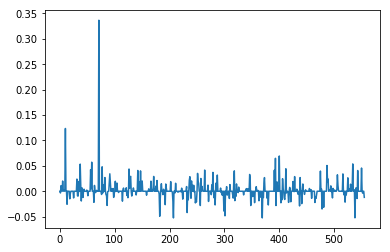

In [189]:
plt.plot(A_lasso[10].coef_)

# LassoCV

In [ ]:
%%time
A_lasso = [linear_model.LassoCV(n_jobs=-1, cv=5, max_iter=10000, tol=0.0001) for i in range(nSegments)]


for i in range(nSegments):
    A_lasso[i].fit(new_X_train, new_Y_train[:, i])
    print(i,"alpha:",A_lasso[i].alpha_,"\nalphas", len(A_lasso[i].alphas_), "\nnb iter:", A_lasso[i].n_iter_)

0 alpha: 19.559602151828933 
alphas 100 
nb iter: 1
1 alpha: 21.25835226917239 
alphas 100 
nb iter: 2
2 alpha: 7.715366357736573 
alphas 100 
nb iter: 25
3 alpha: 15.989093268688558 
alphas 100 
nb iter: 37
4 alpha: 3.152833937488054 
alphas 100 
nb iter: 22
5 alpha: 1.5569692848416357 
alphas 100 
nb iter: 154
6 alpha: 12.31114371822115 
alphas 100 
nb iter: 14
7 alpha: 13.530702271633483 
alphas 100 
nb iter: 2
8 alpha: 12.378631656126986 
alphas 100 
nb iter: 27
9 alpha: 10.212642307206593 
alphas 100 
nb iter: 20
10 alpha: 3.555037466226666 
alphas 100 
nb iter: 31
11 alpha: 3.355783463838919 
alphas 100 
nb iter: 26
12 alpha: 8.628915107889082 
alphas 100 
nb iter: 18
13 alpha: 21.566612596325058 
alphas 100 
nb iter: 2
14 alpha: 8.018261646570954 
alphas 100 
nb iter: 80
15 alpha: 14.039735981987459 
alphas 100 
nb iter: 41
16 alpha: 5.7352431558956525 
alphas 100 
nb iter: 45
17 alpha: 9.81954951063348 
alphas 100 
nb iter: 10
18 alpha: 11.746087598895286 
alphas 100 
nb iter: 

In [11]:
len([a.alpha_ for a in A_lasso])

556

In [12]:
preds_lasso = []

for i in range(nSegments):
    preds_lasso.append(A_lasso[i].predict(new_X_test))

preds_lasso = np.array(preds_lasso)

In [14]:
print("Avec CV")
print("MSE:", mean_squared_error(preds_lasso.T.flatten(), new_Y_test.flatten()))
print("MAE:", mean_absolute_error(preds_lasso.T.flatten(), new_Y_test.flatten()))

Avec CV
MSE: 102.36858121688564
MAE: 6.940723068844308


In [15]:
np.savetxt('coeffs.txt', [a.coef_ for a in A_lasso])

In [16]:
np.savetxt('alphas.txt', [a.alpha_ for a in A_lasso])

In [17]:
np.loadtxt('alphas.txt')

array([19.55960215, 21.25835227,  7.71536636, 15.98909327,  3.15283394,
        1.55696928, 12.31114372, 13.53070227, 12.37863166, 10.21264231,
        3.55503747,  3.35578346,  8.62891511, 21.5666126 ,  8.01826165,
       14.03973598,  5.73524316,  9.81954951, 11.7460876 , 12.1524754 ,
        3.1860771 ,  4.92623326,  3.7132409 ,  3.90111609,  8.41014824,
        8.60739327,  4.25885782,  1.87625933,  8.80092813,  2.14518542,
        9.5907551 , 10.9697632 , 16.63675956, 15.16413269, 15.70330136,
       13.99431794, 17.81093331,  2.7101411 ,  9.61968843,  6.26470895,
        8.81192809, 12.30820325,  8.15827567,  7.09480394,  6.40952217,
        5.08895205,  4.05043243,  4.22460681,  4.08017574, 11.79717584,
       22.85885532,  9.24313937,  8.10158647, 10.16838001,  1.91752335,
        4.02290356,  5.19938701,  3.27592892,  2.71308028,  5.7297592 ,
        5.58858469,  2.80674823, 11.76074447,  6.25552664, 11.54121189,
        5.73065863,  7.60849917, 16.33134954,  5.11073532,  4.13

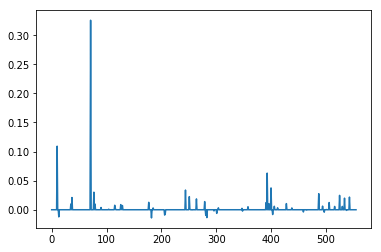

In [23]:
plt.plot(A_lasso[10].coef_)

To do: parralleliser, puis augmenter nombre alphas